# **Load data + Data analysis**

In [3]:
!pip install mlflow azureml-mlflow

In [7]:
import mlflow

In [8]:
experiment_name = 'mlflow1'
mlflow.set_experiment(experiment_name)

2024/10/13 17:33:58 INFO mlflow.tracking.fluent: Experiment with name 'mlflow1' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1728840838861, experiment_id='2617778c-9f33-4898-9756-b3450a02fe54', last_update_time=None, lifecycle_stage='active', name='mlflow1', tags={}>

In [9]:
!pip install datasets

In [10]:
!pip install spacy nltk datasets transformers torch
!python -m spacy download en_core_web_md


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 24.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [11]:
import sys
print (sys.executable)
!pip show datasets

/anaconda/envs/azureml_py38/bin/python
Name: datasets
Version: 2.16.1
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /anaconda/envs/azureml_py38/lib/python3.10/site-packages
Requires: aiohttp, dill, filelock, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, pyarrow, pyarrow-hotfix, pyyaml, requests, tqdm, xxhash
Required-by: azureml-automl-dnn-nlp


In [12]:
!/anaconda/envs/jupyter_env/bin/python -m pip install datasets

In [81]:
from datasets import load_dataset, Dataset

# Enable streaming mode
streamed_dataset = load_dataset("KaungHtetCho/MedicalQA", split="train", streaming=True)

def chunk_generator(streamed_data, chunksize):
    chunk = []
    for i, example in enumerate(streamed_data):
        chunk.append(example)
        if (i + 1) % chunksize == 0:
            yield chunk  # Return the chunk when size is met
            chunk = []
    if chunk:  # Return the last chunk if there are remaining examples
        yield chunk

# Define chunk size
chunksize = 5000

# Initialize a list to store the first 100 rows
first_100_rows = []
row_limit = 100 # Limit to 120,000 rows

for chunk in chunk_generator(streamed_dataset, chunksize):
    chunk_dataset = Dataset.from_list(chunk)

    # If we reach the row limit, slice the chunk to get only the needed rows
    if len(first_100_rows) + len(chunk_dataset) > row_limit:
        remaining_rows = row_limit - len(first_100_rows)
        first_100_rows.extend(chunk[:remaining_rows])
        break
    else:
        first_100_rows.extend(chunk)

    if len(first_100_rows) >= row_limit:
        break

# Convert the list of first 100 rows into a Hugging Face dataset
dataset = Dataset.from_list(first_100_rows)
print(f"Final dataset size: {len(dataset)}")

Final dataset size: 100


In [82]:
import pandas as pd
from datasets import Dataset

# Convert to Pandas DataFrame (dataset is a Hugging Face Dataset object)
train_data = pd.DataFrame(dataset)

# Check for duplicates and null values
initial_size = len(train_data)
train_data = train_data.drop_duplicates()  # Drop duplicate rows
train_data = train_data.dropna()  # Drop rows with any null values

# Size after removing duplicates and null values
after_cleanup_size = len(train_data)
print(f"Original size: {initial_size}")
print(f"Size after removing duplicates and nulls: {after_cleanup_size}")

# Define maximum lengths for context (Patient) and answer (Doctor)
max_len_context = 1000  # Maximum length for context (Patient)
max_len_answer = 500    # Maximum length for answer (Doctor)

# Ensure that 'Patient' and 'Doctor' columns are strings before splitting
train_data['Patient'] = train_data['Patient'].astype(str)
train_data['Doctor'] = train_data['Doctor'].astype(str)

# Filter the dataset based on token length conditions
filtered_data = train_data[
    (train_data['Patient'].str.split().str.len() < max_len_context) &
    (train_data['Doctor'].str.split().str.len() < max_len_answer)
]

# Check the size of the filtered dataset
print(f"Filtered size: {len(filtered_data)}")

# Optionally, convert back to Hugging Face dataset if needed
filtered_dataset = Dataset.from_pandas(filtered_data)


Original size: 100
Size after removing duplicates and nulls: 100
Filtered size: 100


In [83]:
# Select the first 100 entries from the filtered dataset
limited_data = filtered_data.iloc[:120000]

# Check the size of the limited dataset
print(f"Size of limited dataset: {len(limited_data)}")


Size of limited dataset: 100


In [84]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Split dataset into training and validation sets
train_dataset, val_dataset = train_test_split(limited_data, test_size=0.2, random_state=42)

# Convert back to a Hugging Face dataset
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

# Check the sizes of the training and validation sets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 80
Validation dataset size: 20


**check data**

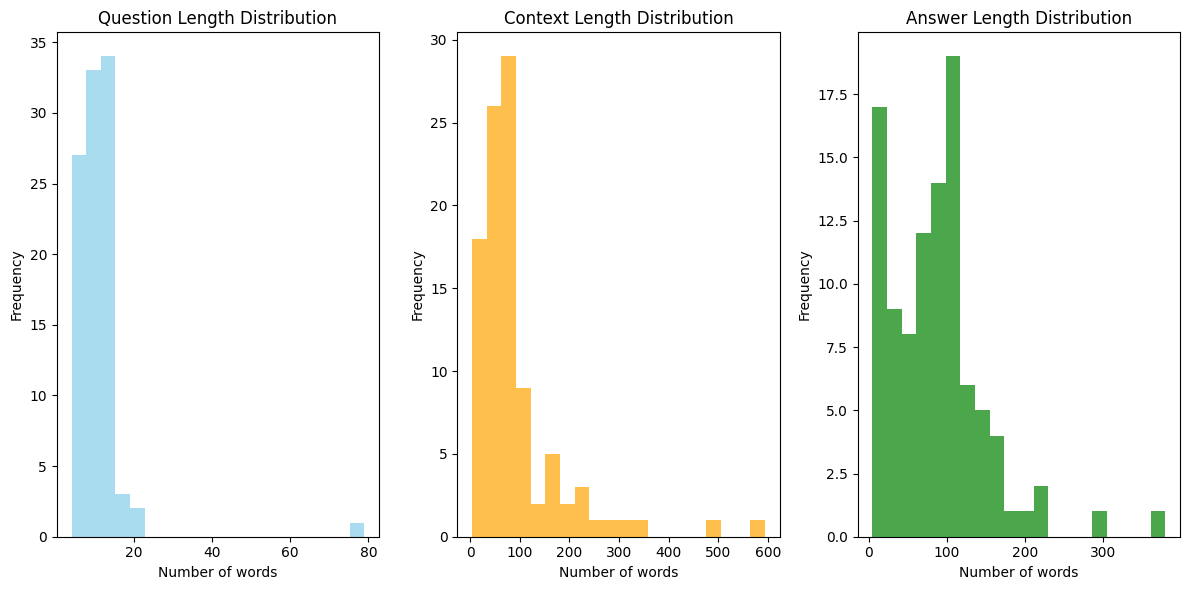

In [85]:

from datasets import load_dataset
import matplotlib.pyplot as plt

# Load the dataset
#dataset = load_dataset("KaungHtetCho/MedicalQA")
#chunksize = 100  # Adjust chunk size as needed
#dataset =for chunk in load_dataset("KaungHtetCho/MedicalQA", chunksize=chunksize):
    # Process each chunk

# Split into train and test (if applicable)
#train_data = dataset['train']

# Analyze question lengths
question_lengths = [len(q.split()) for q in train_data['Description']]
context_lengths = [len(c.split()) for c in train_data['Patient']]
answer_lengths = [len(a.split()) for a in train_data['Doctor']]

# Plot distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(question_lengths, bins=20, color='skyblue', alpha=0.7)
plt.title('Question Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(context_lengths, bins=20, color='orange', alpha=0.7)
plt.title('Context Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(answer_lengths, bins=20, color='green', alpha=0.7)
plt.title('Answer Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# **Libraries**

In [86]:
from datasets import load_dataset,Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel, AdamW
import torch
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader
from transformers import get_scheduler


nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [87]:

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

# Load SpaCy model
nlp = spacy.load('en_core_web_md')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Load BioBert

In [88]:
# Load BioBERT tokenizer and model from Hugging Face
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

In [89]:
# Define the text columns you want to preprocess
text_columns = ['Description', 'Patient', 'Doctor']

# **Preprocissing**

In [90]:
# Preprocessing function using SpaCy and NLTK
def preprocess_text(text):
    # Lowercasing the text
    text = text.lower()

    # Remov special characters
    text=re.sub("^\s+","",text)       #>>>> reomve the distance from the start of sentence
    text=re.sub("\s+$","",text)       #>>>> reomve the distance from the end of sentence
    text=re.sub("(\?|!)+"," ",text)   #>>>>reomve ?!
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization using NLTK
    words = nltk.word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Lemmatization using SpaCy
    doc = nlp(" ".join(words))
    lemmatized_words = [token.lemma_ for token in doc]

    return " ".join(lemmatized_words)

In [91]:
# Apply preprocessing to multiple columns
def preprocess_multiple_columns(dataset, text_columns):
    for column in text_columns:
        dataset = dataset.map(lambda example: {f'preprocessed_{column}': preprocess_text(example[column])})
    return dataset

In [25]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
!/anaconda/envs/jupyter_env/bin/python -m pip install nltk

In [27]:
!/anaconda/envs/jupyter_env/bin/python -c "import nltk; nltk.download('punkt', download_dir='/anaconda/envs/azureml_py38/nltk_data')"

[nltk_data] Downloading package punkt to
[nltk_data]     /anaconda/envs/azureml_py38/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
## Preprocess the dataset columns
#preprocessed_dataset = preprocess_multiple_columns(dataset, text_columns)
# Preprocess the dataset columns
train_dataset = preprocess_multiple_columns(train_dataset, text_columns)
val_dataset = preprocess_multiple_columns(val_dataset, text_columns)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

# **Embadding**

In [93]:
# Generate BioBERT embeddings for the preprocessed text
def generate_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Average pooling the last hidden state to get a single vector representation
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.numpy()

In [94]:
# Apply BioBERT embeddings to the preprocessed text columns
def apply_biobert_embeddings(dataset, text_columns):
    for column in text_columns:
        dataset = dataset.map(lambda example: {f'embeddings_{column}': generate_embeddings(example[f'preprocessed_{column}'])})
    return dataset

# Generate embeddings for preprocessed columns
#embedded_dataset = apply_biobert_embeddings(preprocessed_dataset, [col for col in text_columns])

# Generate embeddings for preprocessed columns
train_dataset = apply_biobert_embeddings(train_dataset, text_columns)
val_dataset = apply_biobert_embeddings(val_dataset, text_columns)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [95]:
# Save the DataFrame with embeddings to a CSV file
train_dataset.to_csv('train_dataset.csv', index=False)
val_dataset.to_csv('val_dataset.csv', index=False)


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

916542

# **Cosine similarity**

In [96]:
# Function to find the most similar answer for a given question using cosine similarity
#Newwwwwwwwwwwwwwwwwwwwwwwwwww one
def find_most_similar(question, dataset, column_name):
    question_embedding = generate_embeddings(question)
    answer_embeddings = np.vstack(dataset[column_name])

    # Calculate cosine similarity
    similarities = cosine_similarity(question_embedding, answer_embeddings)

    # Get the index of the most similar answer
    best_match_idx = int(np.argmax(similarities))  # Ensure this is a Python int

    # Check if the similarity is above a certain threshold to consider it a valid match
    threshold = 0.5  # Adjust this threshold as necessary
    if similarities[0][best_match_idx] < threshold:
        return {"Description": "I'm sorry, I couldn't find a relevant answer."}


    # Return the most similar answer/document
    return {column: dataset[best_match_idx][column] for column in dataset.features.keys() if column.startswith('preprocessed_') or column.startswith('embeddings_')}








In [97]:
# Example chatbot: Ask a medical question and get the best-matching answer
user_question = "What could be the lump in abdominal section??"

# Find the most relevant answer
best_match = find_most_similar(user_question, train_dataset, 'embeddings_Description')


In [98]:
print(" the best match"  , best_match['preprocessed_Doctor'])  # Modify column name as needed
##expected answer
#SThe demographic that should alert you to possible Rubella infection includes patients who have not been vaccinated, such as immigrants or those who are against vaccinations (anti-vaxxers).
#

 the best match hiit gastroenteritis take course antibiotic preprobiotic along omez finedr ashish verma


*ChatBot* simulation

In [99]:


def get_medical_answer(question):
    best_match = find_most_similar(question, train_dataset, 'embeddings_Description')
    return best_match['preprocessed_Doctor']  # Return the preprocessed doctor response

# Example usage
user_question = "What causes mild pain in the right kidney area and stiffness in neck?"
answer = get_medical_answer(user_question)
print("Best match answer:", answer)

Best match answer: helloyou do not need get worriedcyst occur many healthy peoplejust make sure every year u atleast get renal function test do


In [100]:
while True:
    user_question = input("Ask a medical question (or type 'exit' to quit): ")
    if user_question.lower() == 'exit':
        break
    answer = get_medical_answer(user_question)
    print("Best match answer:", answer)

Best match answer: hiit gastroenteritis take course antibiotic preprobiotic along omez finedr ashish verma
Best match answer: hiit gastroenteritis take course antibiotic preprobiotic along omez finedr ashish verma


Top match function (suppose to find top 3 answers but we limit it because data size)

In [101]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming generate_embeddings is defined elsewhere and works as expected
# Function to find top matches
def find_top_matches(question, dataset, column_name, top_n=1):
    # Generate embeddings for the user question
    question_embedding = generate_embeddings(question).reshape(1, -1)

    # Stack the embeddings from the dataset column
    answer_embeddings = np.vstack(dataset[column_name])

    # Calculate cosine similarities between the question embedding and all answer embeddings
    similarities = cosine_similarity(question_embedding, answer_embeddings)

    # Get the indices of the top N most similar answers
    best_match_indices = similarities.argsort()[0][-top_n:][::-1]  # Get top N indices

    # Extract the relevant information for the top matches
    top_matches = []
    for idx in best_match_indices:
        idx = int(idx)  # Ensure idx is a regular Python integer, not a NumPy integer
        match = {
            'Description': dataset[idx]['preprocessed_Description'],
            'Patient': dataset[idx]['preprocessed_Patient'],
            'Doctor': dataset[idx]['preprocessed_Doctor'],
            'Embedding_Description': dataset[idx]['embeddings_Description'],
            'Embedding_Patient': dataset[idx]['embeddings_Patient'],
            'Embedding_Doctor': dataset[idx]['embeddings_Doctor']
        }
        top_matches.append(match)

    return top_matches

# Example usage
user_question = "What could be the lump in abdominal section?"
top_matches = find_top_matches(user_question, train_dataset, 'embeddings_Description', top_n=1)

# Print the matches
for i, match in enumerate(top_matches):
    print(f"Match {i + 1}: {match['Doctor']}")


Match 1: hiit gastroenteritis take course antibiotic preprobiotic along omez finedr ashish verma


In [38]:
#pip install --upgrade transformers


In [102]:
mlflow.autolog()

2024/10/13 19:37:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/10/13 19:37:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/10/13 19:37:52 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/10/13 19:37:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


# **Apply model**

In [55]:
!pip install --upgrade transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 60.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-automl-dnn-nlp 1.57.0 requires torch==1.13.1, but you have torch 2.4.1 which is incompatible.
azureml-automl-dnn-nlp 1.57.0 requires transformers[sentencepiece,torch]<=4.36.2, but you have transformers 4.45.2 which is incompatible.


In [56]:
!pip install transformers==4.36.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 86.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.1
    Uninstalling tokenizers-0.20.1:
      Successfully uninstalled tokenizers-0.20.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.2
    Uninstalling transformers-4.45.2:
      Successfully uninstalled transformers-4.45.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-automl-dnn-nlp 1.57.0 requires torch==1.13.1, but you have torch 2.4.1 which is incompatible.


In [61]:
!/anaconda/envs/jupyter_env/bin/python -m pip install transformers==4.36.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 73.7 MB/s eta 0:00:00


In [73]:
mlflow.end_run()


In [74]:
!pip show transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: transformers
Version: 4.36.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /anaconda/envs/azureml_py38/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: azureml-automl-dnn-nlp


In [104]:
import os
import torch
import mlflow
import mlflow.pytorch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Set environment variable for CUDA memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Set the MLflow tracking URI to your Azure ML workspace
mlflow.set_tracking_uri("azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/1902a231-f66d-497f-a375-3835cf66ad6d/resourceGroups/MyDoc/providers/Microsoft.MachineLearningServices/workspaces/MyDocBot")

# Load a pre-trained language model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load the model
model = AutoModelForCausalLM.from_pretrained(model_name)

# Load your dataset (Update with the correct dataset if needed)
#dataset = load_dataset("KaungHtetCho/MedicalQA")  # Uncomment and replace with your dataset

# Select only the first 100 rows
#dataset = dataset['train'].select(range(100))  # Ensure you use the correct split if necessary

# Preprocessing function
def preprocess_function(examples):
    return {"text": examples["Description"] + " " + examples["Patient"] + " " + examples["Doctor"]}

# Tokenization function
def tokenize_function(examples):
    tokenized = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

# Tokenize the dataset
tokenized_datasets = dataset.map(preprocess_function)
tokenized_datasets = tokenized_datasets.map(tokenize_function, batched=True)

# Print the dataset structure
print(tokenized_datasets)  # Check the structure of the dataset

# Check if CUDA is available and adjust fp16 accordingly
use_fp16 = torch.cuda.is_available()

# Prepare for training
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=2,
    fp16=use_fp16,
)

# Start an MLflow run
with mlflow.start_run():
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("batch_size", training_args.per_device_train_batch_size)
    mlflow.log_param("num_epochs", training_args.num_train_epochs)

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets,  # Use the first 100 rows for training
        eval_dataset=tokenized_datasets,    # Optionally use the same for evaluation
    )

    # Start training
    trainer.train()

    # Evaluate the model
    evaluation_results = trainer.evaluate()
    mlflow.log_metrics(evaluation_results)

    # Save the model to MLflow
    mlflow.pytorch.log_model(model, "model")

# Save the model after training
trainer.save_model("./medical_chatbot_model")

print("Model trained and logged with MLflow.")


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset({
    features: ['Description', 'Patient', 'Doctor', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/accelerate/accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,2.683500,1.752688
2,1.816900,1.630224


2024/10/13 20:18:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/13 20:18:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run olive_spade_vxj3432h at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/1902a231-f66d-497f-a375-3835cf66ad6d/resourceGroups/MyDoc/providers/Microsoft.MachineLearningServices/workspaces/MyDocBot/#/experiments/2617778c-9f33-4898-9756-b3450a02fe54/runs/4995640d-025b-4278-9381-ecc82b0cad21.
2024/10/13 20:18:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/1902a231-f66d-497f-a375-3835cf66ad6d/resourceGroups/MyDoc/providers/Microsoft.MachineLearningServices/workspaces/MyDocBot/#/experiments/2617778c-9f33-4898-9756-b3450a02fe54.


Model trained and logged with MLflow.


In [116]:
# Import MLflow after the training and logging
import mlflow

# Get the latest run
latest_run = mlflow.search_runs(order_by=["start_time desc"])

# Check if any runs were found
if not latest_run.empty:
    # Extract the first row as a dictionary
    latest_run_row = latest_run.iloc[0]

    # Get the run ID
    run_id = latest_run_row.run_id  

    # Get metrics, parameters, and tags
    metrics = {k: latest_run_row[k] for k in latest_run_row.keys() if "metric" in k}
    params = {k: latest_run_row[k] for k in latest_run_row.keys() if "param" in k}
    tags = {k: latest_run_row[k] for k in latest_run_row.keys() if "tag" in k}

    # Print the retrieved metrics, parameters, and tags
    print("Run ID:", run_id)
    print("Metrics:", metrics)
    print("Parameters:", params)
    print("Tags:", tags)
else:
    print("No runs found.")


Run ID: 5331e212-7f3e-4172-9e57-65bf67938bda
Metrics: {'metrics.epoch': nan, 'metrics.loss': nan, 'metrics.learning_rate': nan, 'metrics.eval_runtime': nan, 'metrics.total_flos': nan, 'metrics.eval_loss': nan, 'metrics.eval_steps_per_second': nan, 'metrics.train_runtime': nan, 'metrics.train_loss': nan, 'metrics.train_steps_per_second': nan, 'metrics.train_samples_per_second': nan, 'metrics.eval_samples_per_second': nan, 'params.skip_memory_metrics': None, 'params.tpu_metrics_debug': None, 'params.metric_for_best_model': None, 'params.include_inputs_for_metrics': None}
Parameters: {'params.gradient_checkpointing_kwargs': None, 'params.use_cache': None, 'params.n_layer': None, 'params.problem_type': None, 'params.ddp_find_unused_parameters': None, 'params.ignore_data_skip': None, 'params.return_dict_in_generate': None, 'params.log_level': None, 'params.use_ipex': None, 'params.dataloader_pin_memory': None, 'params.is_decoder': None, 'params.gradient_accumulation_steps': None, 'params.ad

In [105]:
# work in the 500 k 
# import os
# import torch
# import mlflow
# import mlflow.pytorch
# from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
# from datasets import load_dataset

# # Set environment variable for CUDA memory management
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# # Set the MLflow tracking URI to your Azure ML workspace
# mlflow.set_tracking_uri("azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/1902a231-f66d-497f-a375-3835cf66ad6d/resourceGroups/MyDoc/providers/Microsoft.MachineLearningServices/workspaces/MyDocBot")

# # Load a pre-trained language model and tokenizer
# model_name = "gpt2"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token

# # Load the model
# model = AutoModelForCausalLM.from_pretrained(model_name)

# # Load your dataset (Update with the correct dataset if needed)
# # dataset = load_dataset("KaungHtetCho/MedicalQA")  # Uncomment and replace with your dataset

# # Preprocessing function
# def preprocess_function(examples):
#     return {"text": examples["Description"] + " " + examples["Patient"] + " " + examples["Doctor"]}

# # Tokenization function
# def tokenize_function(examples):
#     tokenized = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
#     tokenized["labels"] = tokenized["input_ids"].copy()
#     return tokenized

# # Tokenize the dataset
# dataset = dataset.map(preprocess_function)
# tokenized_datasets = dataset.map(tokenize_function, batched=True)

# # Print the dataset structure
# print(tokenized_datasets)  # Check the structure of the dataset

# # Check if CUDA is available and adjust fp16 accordingly
# use_fp16 = torch.cuda.is_available()

# # Prepare for training
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=10,
#     gradient_accumulation_steps=2,
#     fp16=use_fp16,
# )

# # Start an MLflow run
# with mlflow.start_run():
#     mlflow.log_param("model_name", model_name)
#     mlflow.log_param("batch_size", training_args.per_device_train_batch_size)
#     mlflow.log_param("num_epochs", training_args.num_train_epochs)

#     # Initialize Trainer
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=tokenized_datasets,  # Use entire dataset for training
#         eval_dataset=tokenized_datasets,    # Optionally use the same for evaluation
#     )

#     # Start training
#     trainer.train()

#     # Evaluate the model
#     evaluation_results = trainer.evaluate()
#     mlflow.log_metrics(evaluation_results)

#     # Save the model to MLflow
#     mlflow.pytorch.log_model(model, "model")

# # Save the model after training
# trainer.save_model("./medical_chatbot_model")

# print("Model trained and logged with MLflow.")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024/10/13 20:18:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run yellow_yak_vmhqhnqh at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/1902a231-f66d-497f-a375-3835cf66ad6d/resourceGroups/MyDoc/providers/Microsoft.MachineLearningServices/workspaces/MyDocBot/#/experiments/2617778c-9f33-4898-9756-b3450a02fe54/runs/fec1caa8-46ce-44ee-834e-b47de09b7653.
2024/10/13 20:18:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/1902a231-f66d-497f-a375-3835cf66ad6d/resourceGroups/MyDoc/providers/Microsoft.MachineLearningServices/workspaces/MyDocBot/#/experiments/2617778c-9f33-4898-9756-b3450a02fe54.


KeyError: "Column train not in the dataset. Current columns in the dataset: ['Description', 'Patient', 'Doctor', 'text', 'input_ids', 'attention_mask', 'labels']"

In [113]:
#   


Run ID: 5331e212-7f3e-4172-9e57-65bf67938bda
Metrics: {}
Parameters: {}
Tags: {}


In [114]:

# # Retrieve and print MLflow metrics, parameters, and tags
# run_id ="5331e212-7f3e-4172-9e57-65bf67938bda"  # Get the run ID

# # Fetching metrics, parameters, and tags
# run_info = mlflow.get_run(run_id)
# metrics = run_info.data.metrics
# params = run_info.data.params
# tags = run_info.data.tags

# print("Metrics:", metrics)
# print("Parameters:", params)
# print("Tags:", tags)

Metrics: {}
Parameters: {}
Tags: {'mlflow.user': 'maryam milad wahib messiha wahib', 'mlflow.rootRunId': '5331e212-7f3e-4172-9e57-65bf67938bda', 'mlflow.runName': 'busy_peach_y396x929'}


# **Evaluation**

In [ ]:
!pip install rouge-score
!pip install "datasets[metrics]"
!pip install evaluate

In [ ]:
# Evaluate the model on the validation dataset
evaluation_results = trainer.evaluate()

# Display the evaluation results
print("Evaluation results:", evaluation_results)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

def evaluate_chatbot(train_dataset, val_dataset):
    # Convert true_answers to a list of strings (if it's not already)
    # Use list comprehension to convert each element to string
    true_answers = [str(answer) for answer in val_dataset['Doctor']]
    predicted_answers = []

    # Ensure the model is in evaluation mode and on the right device
    model.eval()  # Set the model to evaluation mode

    # Move model to CPU if it's not already there
    model.to('cpu')

    with torch.no_grad():  # Disable gradient calculation
        for question in val_dataset['Patient']:
            # Tokenize the input question (adjust tokenizer as needed)
            inputs = tokenizer(question, return_tensors='pt', padding=True, truncation=True)

            # Move inputs to CPU
            for key in inputs.keys():
                inputs[key] = inputs[key].to('cpu')

            # Get model predictions
            outputs = model(**inputs)

            # Assuming the last layer provides logits
            logits = outputs.logits  # Adjust according to your model's output structure

            # Get the predicted class for the entire sequence (instead of individual tokens)
            # We can either average the logits across the sequence or take the last token's prediction
            # Here, we average for simplicity:
            predicted_class = torch.argmax(torch.mean(logits, dim=1), dim=1) # Averaging across the sequence length

            # Append predicted class to the list
            predicted_answers.append(predicted_class.item()) # Add this line

    # Before calculating metrics, ensure predicted_answers are strings
    predicted_answers = [str(pred) for pred in predicted_answers]

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_answers, predicted_answers)
    precision = precision_score(true_answers, predicted_answers, average='weighted', zero_division=0)
    recall = recall_score(true_answers, predicted_answers, average='weighted', zero_division=0)
    f1 = f1_score(true_answers, predicted_answers, average='weighted', zero_division=0)


    # Print the evaluation metrics
    print(f"Evaluation Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")

# Call the evaluation function after training
evaluate_chatbot(train_dataset, val_dataset)

In [ ]:
# Install necessary libraries if not already installed
# !pip install nltk rouge-score

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer


# Sample generated responses from the chatbot and corresponding reference responses
generated_responses = [
    "The patient should rest and drink plenty of fluids.",
    "You may take paracetamol for the fever.",
    "It is recommended to see a doctor if the symptoms persist."
]

reference_responses = [
    "The patient should get enough rest and stay hydrated.",
    "Taking paracetamol can help reduce the fever.",
    "If symptoms continue, you should visit a doctor."
]

# Function to calculate BLEU score
def calculate_bleu_score(generated, reference):
    smooth = SmoothingFunction().method1
    return sentence_bleu([nltk.word_tokenize(reference)], nltk.word_tokenize(generated), smoothing_function=smooth)

# Function to calculate ROUGE scores
def calculate_rouge_scores(generated, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, generated)

# Evaluate the chatbot responses
bleu_scores = []
rouge_scores = []

for gen_resp, ref_resp in zip(generated_responses, reference_responses):
    # Calculate BLEU
    bleu = calculate_bleu_score(gen_resp, ref_resp)
    bleu_scores.append(bleu)

    # Calculate ROUGE
    rouge = calculate_rouge_scores(gen_resp, ref_resp)
    rouge_scores.append(rouge)

# Display the results
print("BLEU Scores:")
for i, score in enumerate(bleu_scores):
    print(f"Response {i+1}: {score:.2f}")

print("\nROUGE Scores:")
for i, scores in enumerate(rouge_scores):
    print(f"Response {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value.fmeasure:.2f}")


mini prompt

In [ ]:
# (Optional) Test the model by generating a response
prompt = "Diabetes is a chronic condition that affects how your body metabolizes sugar. Can you list the common symptoms of diabetes?"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to('cuda')  # Move inputs to GPU

output = model.generate(
    inputs["input_ids"],
    max_length=150,  # Increased length for more content
    attention_mask=inputs["attention_mask"],
    num_return_sequences=1,
    temperature=1.0,  # Increased randomness
    top_k=50,
    top_p=0.9
)

response = tokenizer.decode(output[0], skip_special_tokens=True)
print("Response:", response)

## ***onnx***

In [ ]:
model.save('./medical_chatbot_model')

In [ ]:
!pip install onnx
!pip install onnxruntime

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import torch

In [ ]:
!pip install onnxruntime

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Assuming you have already loaded your model and tokenizer
# ...

# Save the model and tokenizer separately
model.save_pretrained('./medical_chatbot_model')  # Assuming 'model' is now a GPT2LMHeadModel
tokenizer.save_pretrained('./medical_chatbot_model')

In [ ]:
!pip install onnxruntime

In [ ]:
!pip install -U tf2onnx

In [ ]:
!python -m tf2onnx.convert --saved-model ./medical_chatbot_model --output ./medical_chatbot_model.onnx

In [ ]:
!pip install azureml-core

In [ ]:
import json
import os
import requests

import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core.model import InferenceConfig
from azureml.core import Environment

from azureml.core.webservice import AciWebservice, Webservice
from azureml.exceptions import WebserviceException

In [ ]:
# The name of the model as it will appear in AzureML
aml_model_name = 'myDoc'  # Updating this requires an update to score.py

# The name of the model endpoint to be created in AzureML
aci_service_name = 'myDoc-onnx'

# The name of the model as it will appear in AI Builder
aib_model_name = "myDoc-v1"

# The local path of the parent of the model directory
model_path = '.'

is_secure = True

In [ ]:
ws = Workspace.from_config('/content/config.json')

In [ ]:
model_root = os.path.join(model_path, './medical_chatbot_model')
model = Model.register(workspace=ws,
                       model_path=model_root,
                       model_name=aml_model_name,
                       tags={'input': "text", 'type': "NLP"},
                       )

print(f"Registered model {model.name}, Version {model.version}")

In [ ]:
%%writefile ./medical_chatbot_model/myenv.yml
name: inference_environment
dependencies:
- python=3.12.7
- pip
- pip:
    - azureml-defaults==1.49.0
    - pillow==9.2.0
    - onnxruntime==1.11.1
    - azureml-contrib-services==1.49.0
    - numpy==1.21.6

In [ ]:
!pip install azureml-contrib-services

In [ ]:
%%writefile ./medical_chatbot_model/score.py
import json
import logging
import os
import numpy as np
import onnxruntime as rt

from azureml.core.model import Model
from azureml.contrib.services.aml_response import AMLResponse



def init():
    """
    This function is called when the container is initialized/started, typically after create/update of the deployment.
    You can write the logic here to perform init operations like caching the model in memory
    """
    global session
    model_dir = Model.get_model_path(model_name="HousePricePrediction-secure")
    # the name of the folder
    model_filename = 'house_price_model.onnx'
    model_path = os.path.join(model_dir, model_filename)

    session = rt.InferenceSession(model_path)
    logging.info("Init complete")


def run(raw_data):
    """
    This function is called for every invocation of the endpoint to perform the actual scoring/prediction.
    """
    logging.info("model 1: request received")
    data = json.loads(raw_data)['input_data']
    input_data = np.array(data, dtype=np.float32)
    if input_data is not None:
        feed = dict([(input.name, input_data[n]) for n, input in enumerate(session.get_inputs())])
        prediction = session.run(None, feed)[0]
        return AMLResponse(json.dumps({'output_data':prediction.tolist()}), 200)
    else:
        return AMLResponse("bad request", 400)

In [ ]:
entry_script = os.path.join(model_root, "score.py")
conda_file = os.path.join(model_root, "myenv.yml")

inference_config = InferenceConfig(runtime="python",
                                   entry_script=entry_script,
                                   conda_file=conda_file)

In [ ]:
service = None

try:
    # get any existing service with the specified name
    service = Webservice(ws, name=aci_service_name)
except WebserviceException as e:
    print(f"Webservice not found: {aci_service_name}")

# Update the service with the new model if the service exists, otherwise deploy a new service
if service:
    print (f"Updating service {aci_service_name}")
    model = Model(workspace=ws, name=aml_model_name)
    service.update(models=[model], inference_config=inference_config, auth_enabled=is_secure)
else:
    print (f"Deploying new service {aci_service_name}")
    deployment_config = AciWebservice.deploy_configuration(cpu_cores = 0.8, memory_gb = 1, auth_enabled=is_secure)
    service = Model.deploy(ws, aci_service_name, [model], inference_config, deployment_config)

service.wait_for_deployment(True)
print(service.state)